In [8]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 23 10:55:17 2016

@author: pschuber
"""
%matplotlib inline
import pandas as pd
import geojson
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
import numpy as np
import shapely.geometry as geom
plt.style.use('ggplot')
import matplotlib.cm as cm
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold
p_data = os.path.expanduser('~') + '/devel/bayeshack-commerce-satellite/data/'
#geoid_to_name = pd.read_csv(p_data + '')

def get_county_areas():
    with open(p_data + "/util/us_counties_500k.json") as json_file:
        counties_geo = geojson.loads(json_file.read().decode("ISO-8859-1"))
    county_dict = {}
    for county in counties_geo["features"]:
        county_code = int(county["properties"]["STATE"] + county["properties"]["COUNTY"])           
        polygon = county["geometry"]
        area = geom.shape(polygon).area
        polygons = []
        if polygon["type"] == 'MultiPolygon':
            for subpoly in polygon["coordinates"]:
                polygons.append({"type": "Polygon", "coordinates": subpoly})
        else:
            polygons.append(polygon)    
        county_dict[county_code] = {"polygons": polygons, "area": area, "state": county["properties"]["STATE"]}
    return county_dict
    
    
def restrict_dates(df):
    res_2014 = df[(df["year"] == 2014)].copy()
    res_2014 = res_2014[res_2014["month"] > 1]
    res_2015 = df[df["year"] == 2015].copy()
    res_2015 = res_2015[res_2015["month"] < 7]
    return pd.concat([res_2014, res_2015])


def counties_per_month():
    counties = pd.read_csv(p_data + 'bayes_viirs_centiles.csv')
    return restrict_dates(counties)
    

def bls_per_month():
    employment = pd.read_csv(p_data + 'full_county_file.csv')
    employment = employment.rename(columns={'mo': 'month'})
    employment.drop('agglvl_code', axis=1, inplace=True)
    employment.drop('industry_code', axis=1, inplace=True)
    return restrict_dates(employment)
    
    
def merge_bls_lum():
    county_areas = get_county_areas()
    bls = bls_per_month()
    luminosity = counties_per_month()
    res = luminosity.head(0) + pd.DataFrame(columns=["emp", "area"])
    overlap = set(bls["area_fips"]).difference(set(luminosity["GEOID"]))
    overlap = list(overlap)
    for _el in luminosity.iterrows():
        print _el[0] 
        el = _el[1].copy()
        m = el["month"]
        fips = el["GEOID"]
        y = el["year"]
        query = bls["emp"][(bls["area_fips"]==fips) & (bls["month"]==m) & (bls["year"]==y)]
        if query.nunique()!=0:
            curr_ix = res.shape[0]
            res.loc[curr_ix] = el.copy()
            res.set_value(curr_ix, "emp", query.as_matrix()[0])
            area = county_areas[fips]['area']
            res.set_value(curr_ix, "area", area)   
    return res
    
    
def plot_counties(counties_to_plot, key='emp'):
    fig = plt.figure()
    ax = fig.gca()
    print len(counties_to_plot)
    max_alpha = max(map(lambda c: c[key]/c["area"], counties_to_plot))
    res = []
    for county in counties_to_plot:
        for poly in county["polygons"]:
            res.append( county["emp"] / county["area"] / max_alpha )
            ax.add_patch(PolygonPatch(poly, color="%0.5f" % (county["emp"] / county["area"] / max_alpha)))
    ax.set_title('Emp Area Map of Counties, January 2015')
    _ = ax.axis('scaled')      

  
# get dataset 
#viirs_emp = merge_bls_lum()
#viirs_emp.to_csv(p_data + "viirs_emp.csv")
orig_df = pd.read_csv(p_data + "viirs_emp.csv")
viirs_emp = pd.read_csv(p_data + "viirs_emp.csv")
for i in range(101):
    viirs_emp.drop('pct.%d' % i, axis=1, inplace=True)
viirs_emp.drop('Unnamed: 0', axis=1, inplace=True)
arr = viirs_emp.as_matrix().astype(np.float)
print "arr consists of entries", viirs_emp.head(0).columns
arr[:, 4][arr[:, -1] == 2015.] = arr[:, 4][arr[:, -1] == 2015.] + 12
    
# plot employment of all counties
#counties_to_plot = []
#county_areas = get_county_areas()
#for k, v in county_areas.iteritems():
#    new_dict = v.copy()
#    try:
#        new_dict.update({"emp": viirs_emp[(viirs_emp["GEOID"]==k) & (viirs_emp["month"]==1) & (viirs_emp["year"]==2015)]["emp"].as_matrix()[0]})
#    except:
#        print "Skipped", k
#        continue
#    counties_to_plot.append(new_dict) 




arr consists of entries Index([u'GEOID', u'area', u'char', u'emp', u'month', u'sum', u'year'], dtype='object')


## Densities colored by time

Nb of points in month 2: 3219
Nb of points in month 3: 3216
Nb of points in month 4: 3190
Nb of points in month 5: 2112
Nb of points in month 6: 777
Nb of points in month 7: 1654
Nb of points in month 8: 3053
Nb of points in month 9: 3200
Nb of points in month 10: 3219
Nb of points in month 11: 3219
Nb of points in month 12: 3219
Nb of points in month 13: 3219
Nb of points in month 14: 3219
Nb of points in month 15: 3208
Nb of points in month 16: 3086
Nb of points in month 17: 1434


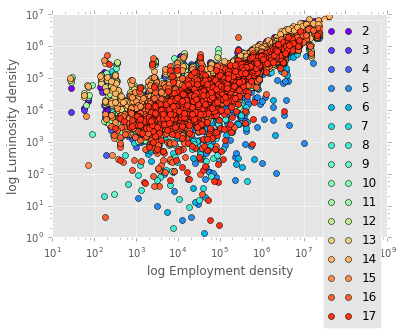

In [2]:
### plot monthly colored densities
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 17))
for i, c in zip(range(2, 18), colors):
    print "Nb of points in month %d: %d" % (i, len(arr[arr[:, 4]==i]))
    plt.loglog(arr[arr[:, 4]==i][:, 3]/arr[arr[:, 4]==i][:, 1], arr[arr[:, 4]==i][:, -2]/arr[arr[:, 4]==i][:, 1], 'o', color=c, label='%d' % i)
plt.xlabel("log Employment density")
plt.ylabel("log Luminosity density")
plt.legend()
plt.show() 
#plt.savefig(p_data + "densities.png", dpi=300)
   

## Density Differences by Time

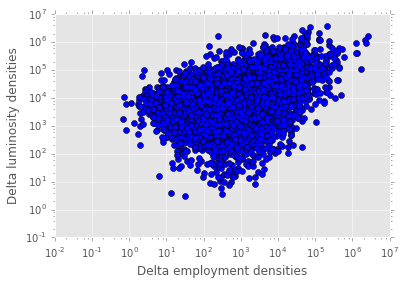

In [7]:
## plot the deltas
plt.figure()
for k, fips in enumerate(list(set(arr[:, 0]))):
    curr_county = arr[arr[:, 0] == fips]
    curr_county = curr_county[np.argsort(curr_county[:, 4])]
    curr_county[:, 3] /= curr_county[:, 1]
    curr_county[:, -2] /= curr_county[:, 1]
    delta_emp_dens = curr_county[1:, 3] - curr_county[:-1, 3]
    delta_lum_dens = curr_county[1:, -2] - curr_county[:-1, -2]
    plt.loglog(delta_emp_dens, delta_lum_dens, 'bo')
    plt.xlabel("Delta employment densities")
    plt.ylabel("Delta luminosity densities")
plt.show()
#plt.savefig(p_data + "deltas.png", dpi=300)

## RandomForestRegressor -- Inference of Employment

In [15]:
# Random Forest Regression Model to regress employment density from
# luminosity percentiles and luminosity density
emp_dens = arr[:, 3]/arr[:, 1]
lum_dens = arr[:, -2]/arr[:, 1]
Y = emp_dens
X = np.concatenate((orig_df.as_matrix()[:, 6:-3], lum_dens[:, None]), axis=1)
kf = KFold(arr.shape[0], n_folds=5)
for train_index, test_index in kf:
    rfc = RandomForestRegressor(n_estimators=30, n_jobs=4, max_features=0.33)
    rfc.fit(X[train_index], Y[train_index])
    print rfc.score(X[test_index], Y[test_index])
names = orig_df.head(0).columns[6:-3]
names = np.array(names.tolist()+['lum_dens'])
print names[np.argsort(rfc.feature_importances_)]

-0.993939695626
0.359669008813
0.65049154004
0.477316608772
0.759148633617
['pct.84' 'pct.25' 'pct.14' 'pct.62' 'pct.21' 'pct.68' 'pct.20' 'pct.63'
 'pct.82' 'pct.23' 'pct.58' 'pct.44' 'pct.16' 'pct.13' 'pct.24' 'pct.86'
 'pct.26' 'pct.88' 'pct.43' 'pct.87' 'pct.56' 'pct.53' 'pct.15' 'pct.30'
 'pct.90' 'pct.57' 'pct.11' 'pct.95' 'pct.92' 'pct.89' 'pct.77' 'pct.48'
 'pct.42' 'pct.76' 'pct.74' 'pct.18' 'pct.71' 'pct.40' 'pct.31' 'pct.93'
 'pct.37' 'pct.51' 'pct.55' 'pct.29' 'pct.38' 'pct.80' 'pct.33' 'pct.49'
 'pct.75' 'pct.41' 'pct.52' 'pct.45' 'pct.94' 'pct.10' 'pct.32' 'pct.69'
 'pct.67' 'pct.78' 'pct.54' 'pct.79' 'pct.17' 'pct.81' 'pct.39' 'pct.35'
 'pct.65' 'pct.2' 'pct.72' 'pct.4' 'pct.27' 'pct.34' 'pct.66' 'pct.19'
 'pct.61' 'pct.28' 'pct.59' 'pct.47' 'pct.50' 'pct.70' 'pct.85' 'pct.12'
 'pct.73' 'pct.100' 'pct.91' 'pct.64' 'pct.22' 'pct.83' 'pct.60' 'pct.46'
 'pct.36' 'pct.96' 'pct.3' 'pct.5' 'pct.8' 'pct.6' 'pct.1' 'pct.7'
 'lum_dens' 'pct.0' 'pct.97' 'pct.9' 'pct.98']
